In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [2]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.

save_folder = 'SGD-pi-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

In [3]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [4]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    inv_sm_pi_c = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c,inv_sm_pi_c

In [5]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,inv_sm_pi_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,inv_sm_pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [6]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
inv_sm_pi_c_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [7]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,inv_sm_pi_c_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,inv_sm_pi_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.StepLR(optimizer_clustering,step_size=10,gamma=0.9)


In [9]:
def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,input_dim),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

    return BCE+beta*KLD



In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))


In [11]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [12]:

def initial_train(epochs):
    for epoch in range(1, epochs +1):
        train(epoch)
        test(epoch)
        scheduler.step()
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [13]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [14]:
def gauss(mus,logvars,mu_c,logvar_c,inv_sm_pi_c,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [24]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()

In [16]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [17]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,inv_sm_pi_c_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -(((F.softmax(inv_sm_pi_c_f,dim=2)*((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [18]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_c_f=logvar_c_g,inv_sm_pi_c_f=inv_sm_pi_c_g)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

#        print(mu_c_g)
#        print('var_c='.format(logvar_c_g.exp()))

#        print('mu={}'.format(mu.view(-1,latent_dim,1).squeeze()))
#        print('prec_c={}'.format((1./logvar_c_g.exp()).squeeze()))
#        print('quad={}'.format(((((mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('quadvar={}'.format((((logvar.view(-1,latent_dim,1).exp())/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('expDKL={}'.format((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp().squeeze()))
#        print('logDKL={}'.format((((F.softmax(inv_sm_pi_c_g,dim=2)*((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).squeeze()))

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

#        if batch_idx == 5:
#            break

In [19]:
def test_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [20]:
def train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [21]:
mu_c_g,logvar_c_g,F.softmax(inv_sm_pi_c_g,dim=2)

(tensor([[[ 0.0205,  0.3335,  1.6945,  2.2869, -0.4991, -1.0566, -1.0713,
           -0.8535,  0.7981, -1.0285],
          [-0.1525,  0.6375, -1.0685, -1.3792,  1.6177,  1.7170,  1.1194,
            0.3443,  0.6458,  1.4226],
          [ 0.0368,  0.2790, -0.0207,  1.0427, -0.1859, -0.3761, -0.2756,
            0.3061,  2.3599,  0.7331],
          [ 0.2201, -1.0485,  0.5327,  0.2386,  1.2062, -1.6211, -0.7480,
           -0.4070,  0.3087,  0.0401],
          [-0.5800, -0.2749, -0.8610, -1.3363, -0.7912, -0.8955, -0.1658,
            0.4336, -0.4479,  0.3492],
          [ 0.5088,  0.2571,  0.2606,  0.8515,  0.3374,  1.3715,  0.9135,
            0.3237, -0.9576, -0.0560],
          [-1.2943,  0.8086, -1.0563, -0.7301,  2.3736,  0.2767,  0.2376,
            0.5423, -1.4447,  2.5474],
          [-1.9158,  2.7035,  1.6561, -0.6765, -1.1811,  1.3786,  1.8159,
           -2.1320, -1.3604,  0.4366],
          [-0.1559,  0.6311, -1.4892,  1.4963, -0.4967, -0.2177, -1.7407,
           -1.5228, -0

In [117]:
for i in range(470):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    scheduler.step()
    scheduler_clustering.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: 103.857012
====> Test set loss: 1.0533
Train Epoch: 1 [0/60000 (0%)]	Loss: 100.993691
====> Test set loss: 1.0347
Train Epoch: 2 [0/60000 (0%)]	Loss: 103.142334
====> Test set loss: 0.9805
Train Epoch: 3 [0/60000 (0%)]	Loss: 102.648145
====> Test set loss: 1.0285
Train Epoch: 4 [0/60000 (0%)]	Loss: 97.965850
====> Test set loss: 1.0090
Train Epoch: 5 [0/60000 (0%)]	Loss: 100.861504
====> Test set loss: 1.0131
Train Epoch: 6 [0/60000 (0%)]	Loss: 102.341680
====> Test set loss: 0.9734
Train Epoch: 7 [0/60000 (0%)]	Loss: 103.566299
====> Test set loss: 0.9891
Train Epoch: 8 [0/60000 (0%)]	Loss: 96.260537
====> Test set loss: 1.0486
Train Epoch: 9 [0/60000 (0%)]	Loss: 102.867432
====> Test set loss: 0.9964
Train Epoch: 10 [0/60000 (0%)]	Loss: 98.901152
====> Test set loss: 1.0266
Train Epoch: 11 [0/60000 (0%)]	Loss: 99.044932
====> Test set loss: 1.0831
Train Epoch: 12 [0/60000 (0%)]	Loss: 101.907754
====> Test set loss: 1.0585
Train Epoch: 13 [0/60000 (

In [118]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()

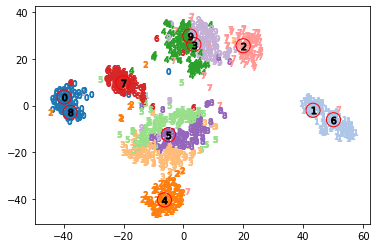

In [119]:
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

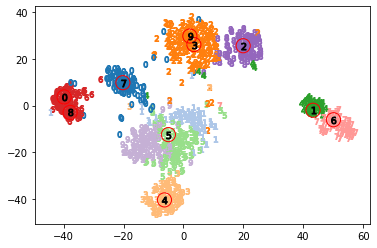

In [120]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

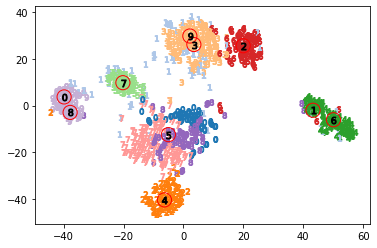

In [121]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

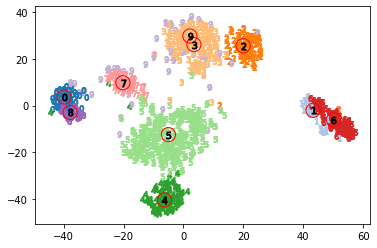

In [122]:

_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,inv_sm_pi_c_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [123]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [124]:
optimizer.param_groups[0]['lr']

1.030755041464024e-05

In [125]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [126]:
correspond_matrix

tensor([[ 53.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  33.,   7.],
        [  0.,  37.,   0.,   0.,   0.,   0.,  88.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  95.,   4.,   0.,   0.,   0.,   3.],
        [  0.,   0.,   1.,   0.,   0., 105.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  91.,   0.,   1.,   0.,   1.,   0.,  14.],
        [  0.,   0.,   0.,   1.,   0., 103.,   0.,   1.,   0.,   2.],
        [  0.,   0.,   0.,   0.,   1.,   4.,   0.,  70.,   0.,  10.],
        [  0.,   0.,  80.,   3.,   1.,   0.,   0.,   0.,   0.,   9.],
        [  0.,   0.,   1.,   2.,   0.,  83.,   0.,   0.,   0.,   3.],
        [  0.,   0.,   5.,  77.,   0.,   3.,   0.,   0.,   0.,   7.]])

In [127]:
correspond_matrix.sum()

tensor(1000.)

In [128]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([ 53.,  37.,  80.,  91.,  95., 105.,  88.,  70.,  33.,  14.]),
indices=tensor([0, 1, 7, 4, 2, 3, 1, 6, 0, 4]))

In [129]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.6660)

In [130]:
F.softmax(inv_sm_pi_c_g,dim=2)

tensor([[[0.0601, 0.0386, 0.1015, 0.1590, 0.1011, 0.2865, 0.0695, 0.0873,
          0.0339, 0.0627]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [131]:
mu_c_g

tensor([[[ 4.2756e-02,  1.8344e+00,  7.0663e-01,  1.2605e-01,  2.2102e-01,
           1.9216e-02,  3.5773e-01, -2.6988e-01,  1.2732e-01, -7.1441e-01],
         [ 9.3776e-01, -7.1341e-02,  1.1705e+00,  1.2933e-01,  1.6323e+00,
           1.4925e+00, -6.8134e-01, -1.1098e+00,  6.2344e-01,  2.6992e-01],
         [-1.8650e-01,  7.9229e-01,  1.3069e-01, -3.1151e-01, -1.6954e+00,
           1.2937e+00,  7.9304e-01,  1.6835e-01, -2.3818e-01, -7.7805e-01],
         [-2.6788e-03, -2.7007e-03, -2.7581e-03, -2.6468e-03, -2.3669e-03,
          -2.5627e-03, -2.6789e-03, -2.5585e-03, -2.7435e-03, -2.5586e-03],
         [-7.5577e-01, -1.9990e+00, -1.7922e-02, -1.4932e+00, -9.6710e-01,
          -9.9718e-01, -1.3837e+00, -2.2228e+00, -1.0754e+00, -1.3560e+00],
         [ 4.0559e-01,  3.0731e-01, -2.9432e-01, -7.0774e-02,  6.9397e-01,
           1.1807e-01,  3.0690e-01, -1.1469e-01,  5.0976e-01, -3.1361e-01],
         [-5.0817e-01,  1.3394e+00, -2.2642e+00, -1.6621e+00,  2.4762e+00,
           5.2540e-

In [132]:
logvar_c_g.exp()

tensor([[[1.4480, 3.1248, 1.7623, 1.4442, 2.0280, 2.3243, 2.0994, 0.8640,
          1.1497, 2.2624],
         [0.3834, 0.3821, 0.5589, 0.3556, 1.5503, 0.8245, 0.2484, 0.1450,
          0.2122, 1.4103],
         [0.3700, 0.0417, 0.5148, 0.6285, 1.1465, 0.7294, 0.0420, 0.4823,
          0.2682, 1.4160],
         [0.0041, 0.0042, 0.0041, 0.0041, 0.0041, 0.0041, 0.0042, 0.0041,
          0.0041, 0.0041],
         [0.6992, 0.2467, 0.5001, 0.3265, 0.8330, 0.4567, 0.2512, 0.4087,
          0.5436, 1.1411],
         [0.3332, 0.0773, 0.2582, 0.2066, 1.1969, 0.6046, 0.0739, 0.1748,
          0.1673, 0.7415],
         [0.6210, 0.2543, 1.7353, 0.2981, 0.9139, 0.7186, 0.2653, 0.3538,
          0.2095, 1.9391],
         [0.2244, 0.3761, 0.3968, 0.3375, 1.6143, 0.7588, 0.2584, 0.5222,
          0.3730, 2.3034],
         [0.5357, 0.0551, 0.4760, 0.3462, 1.3649, 0.5723, 0.0519, 0.2157,
          0.3082, 1.0079],
         [0.0041, 0.0042, 0.0041, 0.0041, 0.0041, 0.0041, 0.0042, 0.0041,
          0.0041,

In [133]:
mus_g[0:10,:,0]

tensor([[-2.6993e-01, -5.7208e-01,  8.0299e-01, -2.6243e-03, -1.2637e+00,
          3.9761e-01,  8.1798e-01,  3.1429e+00, -3.6502e-01, -5.2061e-04],
        [ 1.7746e+00,  1.1175e+00,  4.0311e-01, -2.5179e-03, -1.4263e+00,
          9.8933e-01,  1.6768e+00, -2.6614e+00, -1.6704e+00,  3.1248e-05],
        [-1.2777e+00, -1.5697e+00, -6.1876e-01, -2.1548e-03, -2.1042e+00,
          3.0003e-01,  2.6327e-01, -1.4074e+00, -1.2021e+00, -6.8570e-04],
        [ 3.2655e-01,  2.0331e+00,  6.0747e-01, -2.8481e-03,  9.9662e-01,
         -4.1613e-01, -1.8031e+00,  2.7881e+00, -1.8957e+00, -1.6348e-04],
        [ 1.2527e+00,  4.2952e-01, -7.1240e-01, -2.5341e-03, -2.3381e-01,
          8.9224e-01,  6.7969e-01, -2.8453e+00, -2.3178e+00, -1.0725e-04],
        [ 3.4842e-01,  1.8753e+00,  5.9833e-01, -2.2935e-03, -1.7990e+00,
         -5.6228e-01,  1.5613e+00,  4.7193e-01, -2.5537e-01,  3.0263e-05],
        [ 9.3776e-01, -6.8578e-01,  1.6669e-01, -2.5142e-03, -2.4613e+00,
         -4.4208e-01,  2.3483e-0

In [134]:
logvars_g.exp()[0:10,:,0]

tensor([[0.0089, 0.0189, 0.0406, 0.0042, 0.0244, 0.0721, 0.0158, 0.0266, 0.0496,
         0.0042],
        [0.0065, 0.0120, 0.0150, 0.0041, 0.0142, 0.0293, 0.0107, 0.0095, 0.0134,
         0.0041],
        [0.0041, 0.0062, 0.0052, 0.0041, 0.0110, 0.0178, 0.0036, 0.0044, 0.0100,
         0.0041],
        [0.0082, 0.0171, 0.0782, 0.0041, 0.0132, 0.0326, 0.0150, 0.0191, 0.0220,
         0.0041],
        [0.0042, 0.0114, 0.0096, 0.0040, 0.0131, 0.0258, 0.0067, 0.0085, 0.0110,
         0.0041],
        [0.0066, 0.0123, 0.0106, 0.0040, 0.0149, 0.0227, 0.0073, 0.0073, 0.0189,
         0.0041],
        [0.0090, 0.0100, 0.0109, 0.0041, 0.0126, 0.0191, 0.0172, 0.0092, 0.0157,
         0.0041],
        [0.0064, 0.0121, 0.0160, 0.0041, 0.0113, 0.0277, 0.0074, 0.0052, 0.0200,
         0.0041],
        [0.0052, 0.0083, 0.0053, 0.0041, 0.0100, 0.0186, 0.0057, 0.0043, 0.0121,
         0.0041],
        [0.0142, 0.0197, 0.0397, 0.0042, 0.0286, 0.0586, 0.0274, 0.0195, 0.0483,
         0.0042]], device='c